# **CNN-BiLSTM for AF Detection**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, 
                                      BatchNormalization, Dense, Bidirectional, LSTM)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")

2025-10-21 07:14:07.524081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761030847.695147      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761030847.753355      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU detected, using CPU")

GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

**Load Data**

In [ ]:
DATASET_PATH = '/kaggle/input/mit-bih-atrial-fibrillation-stratified-splits/stratified_splits'
# DATASET: https://www.kaggle.com/datasets/achmadrohmandzonizm/mit-bih-atrial-fibrillation-stratified-splits

print("Loading data...")
train_data = np.load(f'{DATASET_PATH}/train_data.npz')
val_data = np.load(f'{DATASET_PATH}/val_data.npz')
test_data = np.load(f'{DATASET_PATH}/test_data.npz')

X_train, y_train = train_data['X'], train_data['y']
X_val, y_val = val_data['X'], val_data['y']
X_test, y_test = test_data['X'], test_data['y']

# Reshape for CNN
X_train = X_train.reshape(-1, X_train.shape[1], 1).astype(np.float32)
X_val = X_val.reshape(-1, X_val.shape[1], 1).astype(np.float32)
X_test = X_test.reshape(-1, X_test.shape[1], 1).astype(np.float32)

n_timesteps = X_train.shape[1]

print(f"\nData loaded:")
print(f"Train: {X_train.shape}, AF: {np.sum(y_train==1)/len(y_train):.1%}")
print(f"Val:   {X_val.shape}, AF: {np.sum(y_val==1)/len(y_val):.1%}")
print(f"Test:  {X_test.shape}, AF: {np.sum(y_test==1)/len(y_test):.1%}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: Normal={class_weights[0]:.3f}, AF={class_weights[1]:.3f}")

Loading data...

Data loaded:
Train: (70340, 2500, 1), AF: 35.6%
Val:   (28077, 2500, 1), AF: 48.5%
Test:  (19118, 2500, 1), AF: 40.3%

Class weights: Normal=0.776, AF=1.405


**Model Architecture**

In [5]:
LEARNING_RATE = 0.0003
DROPOUT_RATE = 0.4
L2_REG = 0.0005
BATCH_SIZE = 128
EPOCHS = 100

print("="*70)
print("HYPERPARAMETERS")
print("="*70)
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate:  {DROPOUT_RATE}")
print(f"L2 Reg:        {L2_REG}")
print(f"Batch Size:    {BATCH_SIZE}")
print(f"Max Epochs:    {EPOCHS}")
print("="*70)

def create_model(lr=LEARNING_RATE, dropout=DROPOUT_RATE, l2_reg=L2_REG):
    inp = Input(shape=(n_timesteps, 1))
    
    # CNN blocks
    x = Conv1D(32, 7, activation='relu', padding='same', 
               kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(dropout * 0.75)(x)
    
    x = Conv1D(64, 5, activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(dropout)(x)
    
    x = Conv1D(128, 3, activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(dropout)(x)
    
    # BiLSTM layer
    x = Bidirectional(LSTM(64, return_sequences=False,
                           dropout=dropout * 0.75,
                           kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(dropout * 1.25)(x)
    
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Preview
print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
model = create_model()
model.summary()
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Model size: ~{total_params * 4 / 1024**2:.2f} MB")
print("="*70)

HYPERPARAMETERS
Learning Rate: 0.0003
Dropout Rate:  0.4
L2 Reg:        0.0005
Batch Size:    128
Max Epochs:    100

MODEL ARCHITECTURE


I0000 00:00:1761030887.571633      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2500, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2500, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 833, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 833, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 833, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 833, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 277, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 277, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 277, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 277, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,297 (559.75 KB)

 Trainable params: 142,849 (558.00 KB)

 Non-trainable params: 448 (1.75 KB)


Total parameters: 143,297
Model size: ~0.55 MB


**Training Model**

In [6]:
print("\n" + "="*70)
print("TRAINING MODEL")
print("="*70)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)
]

print("\nStarting training...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print()

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

model.save('/kaggle/working/final_model.h5')
print("\n✓ Model saved: final_model.h5")


TRAINING MODEL

Starting training...
Batch size: 128
Max epochs: 100

Epoch 1/100


I0000 00:00:1761030898.900417      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


550/550 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.7082 - auc: 0.7628 - loss: 0.8246 - precision: 0.5852 - recall: 0.6546 - val_accuracy: 0.4625 - val_auc: 0.5242 - val_loss: 2.3289 - val_precision: 0.4672 - val_recall: 0.7752 - learning_rate: 3.0000e-04
Epoch 2/100
550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9117 - auc: 0.9646 - loss: 0.4535 - precision: 0.8659 - recall: 0.8915 - val_accuracy: 0.4866 - val_auc: 0.6264 - val_loss: 2.4826 - val_precision: 0.4835 - val_recall: 0.8665 - learning_rate: 3.0000e-04
Epoch 3/100
550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9498 - auc: 0.9881 - loss: 0.3222 - precision: 0.9112 - recall: 0.9528 - val_accuracy: 0.5401 - val_auc: 0.7013 - val_loss: 1.9171 - val_precision: 0.5153 - val_recall: 0.8648 - learning_rate: 3.0000e-04
Epoch 4/100
550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9691 - auc: 0.9939 - loss: 0.2527 - precision: 0.9432 - recall: 0.9722 - val_accuracy: 0.6643 - val_auc: 0.6966 - val_loss: 

**Evaluation**

In [7]:
def evaluate(model, X, y, set_name):
    """Evaluate model"""
    y_proba = model.predict(X, verbose=0)
    y_pred = (y_proba > 0.5).astype(int).flatten()
    
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1 = 2 * (prec * sens) / (prec + sens)
    auc = roc_auc_score(y, y_proba)
    
    print(f"\n{set_name} Results:")
    print(f"  Accuracy:    {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Sensitivity: {sens:.4f} ({sens*100:.2f}%)")
    print(f"  Specificity: {spec:.4f} ({spec*100:.2f}%)")
    print(f"  Precision:   {prec:.4f} ({prec*100:.2f}%)")
    print(f"  F1-Score:    {f1:.4f}")
    print(f"  AUC:         {auc:.4f}")
    
    return {
        'y_pred': y_pred, 'y_proba': y_proba,
        'acc': acc, 'sens': sens, 'spec': spec, 
        'prec': prec, 'f1': f1, 'auc': auc,
        'cm': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

print("\n" + "="*70)
print("EVALUATION")
print("="*70)

train_results = evaluate(model, X_train, y_train, "Training")
val_results = evaluate(model, X_val, y_val, "Validation")
test_results = evaluate(model, X_test, y_test, "Test")

# Confusion matrix
cm = test_results['cm']
print(f"\nConfusion Matrix (Test):")
print(f"              Predicted")
print(f"            Normal    AF")
print(f"Actual Normal {cm['tn']:6d} {cm['fp']:6d}")
print(f"       AF     {cm['fn']:6d} {cm['tp']:6d}")

print("\nClassification Report (Test):")
print(classification_report(y_test, test_results['y_pred'], 
                          target_names=['Normal', 'AF'], digits=4))


EVALUATION

Training Results:
  Accuracy:    0.9969 (99.69%)
  Sensitivity: 0.9952 (99.52%)
  Specificity: 0.9978 (99.78%)
  Precision:   0.9960 (99.60%)
  F1-Score:    0.9956
  AUC:         0.9997

Validation Results:
  Accuracy:    0.8809 (88.09%)
  Sensitivity: 0.9729 (97.29%)
  Specificity: 0.7944 (79.44%)
  Precision:   0.8165 (81.65%)
  F1-Score:    0.8879
  AUC:         0.9407

Test Results:
  Accuracy:    0.9118 (91.18%)
  Sensitivity: 0.9274 (92.74%)
  Specificity: 0.9012 (90.12%)
  Precision:   0.8635 (86.35%)
  F1-Score:    0.8943
  AUC:         0.9578

Confusion Matrix (Test):
              Predicted
            Normal    AF
Actual Normal  10294   1128
       AF        559   7137

Classification Report (Test):
              precision    recall  f1-score   support

      Normal     0.9485    0.9012    0.9243     11422
          AF     0.8635    0.9274    0.8943      7696

    accuracy                         0.9118     19118
   macro avg     0.9060    0.9143    0.9093     1

**Visualizations**

✓ Saved: training_history.png


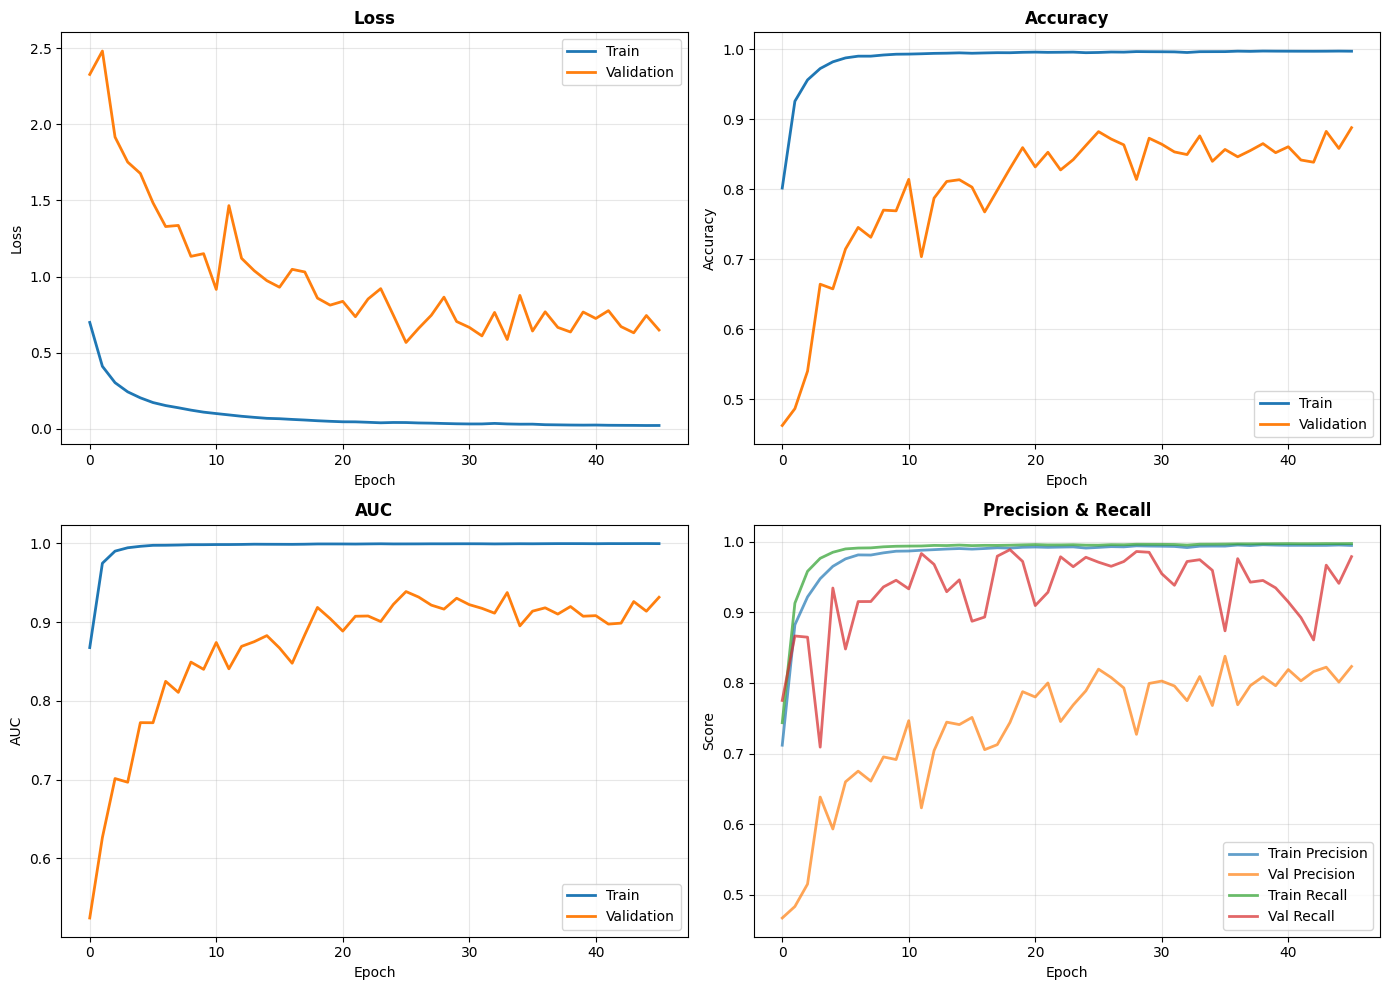

✓ Saved: roc_curves.png


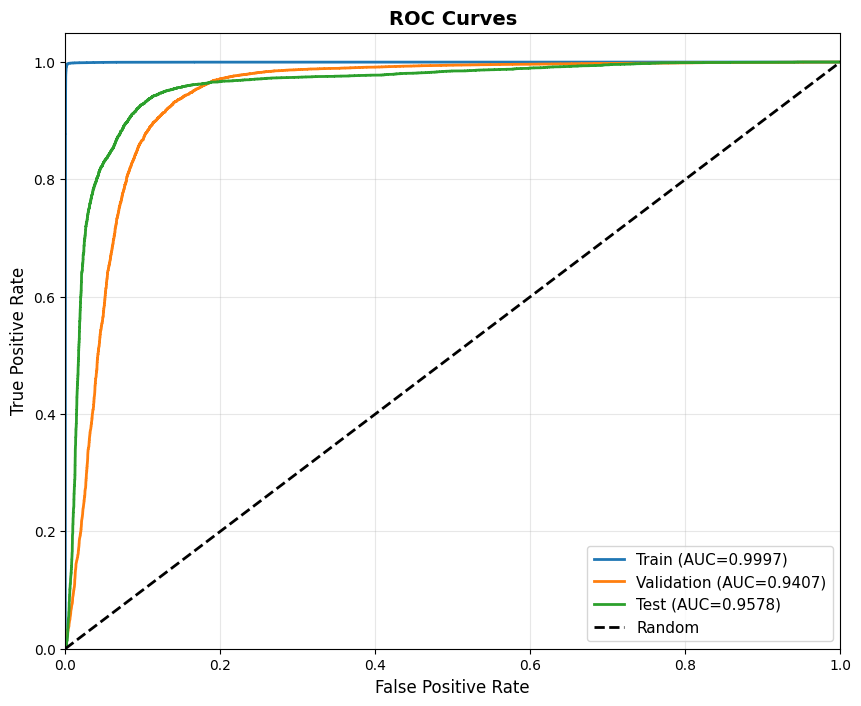

✓ Saved: confusion_matrix.png


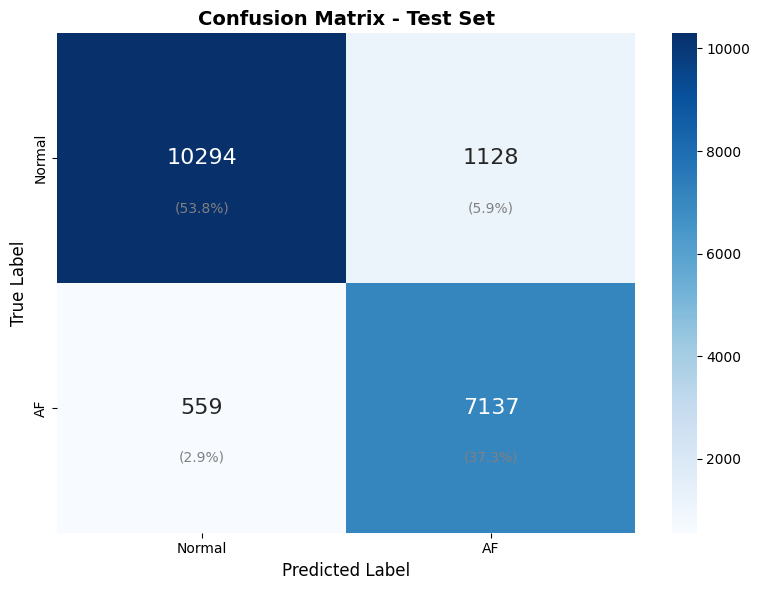

✓ Saved: metrics_comparison.png


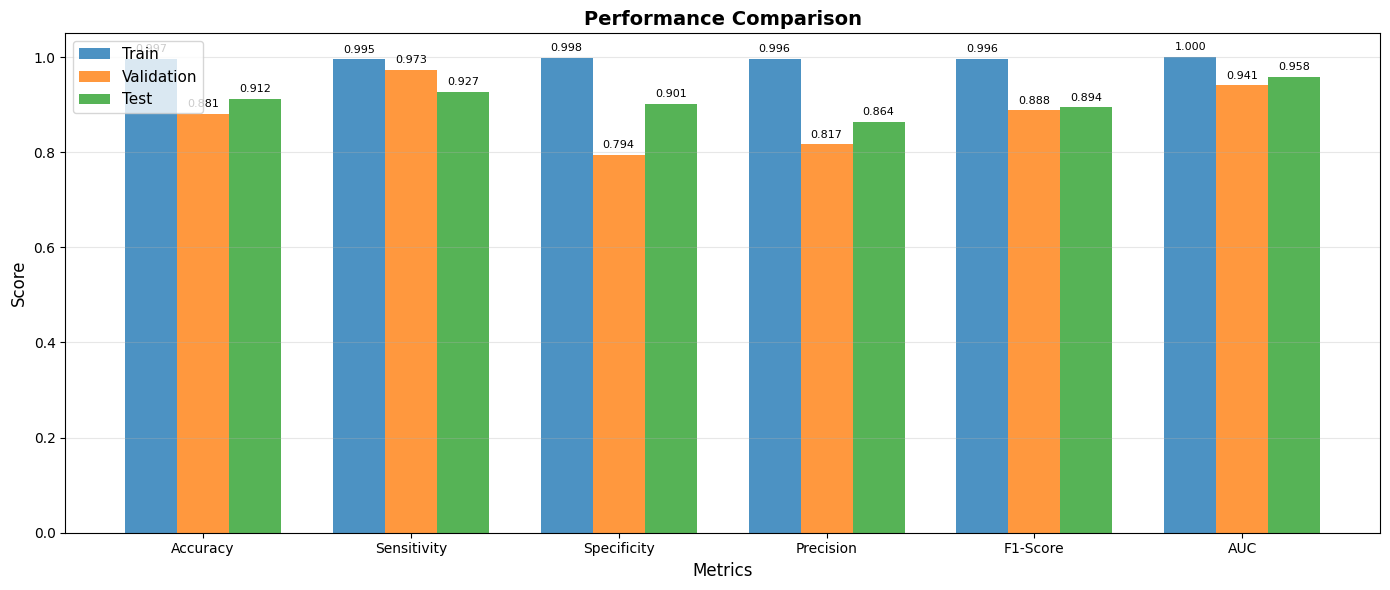


SUMMARY

Hyperparameters:
  Learning Rate: 0.0003
  Dropout:       0.4
  L2 Reg:        0.0005
  Batch Size:    128
  Epochs Trained: 46

Test Performance:
  Accuracy:    0.9118 (91.18%)
  Sensitivity: 0.9274 (92.74%)
  Specificity: 0.9012 (90.12%)
  AUC:         0.9578
  F1-Score:    0.8943

Saved files:
  1. final_model.h5
  2. training_history.png
  3. roc_curves.png
  4. confusion_matrix.png
  5. metrics_comparison.png


In [8]:
# 1. Training History
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Loss', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 1].set_title('Accuracy', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Validation', linewidth=2)
axes[1, 0].set_title('AUC', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', linewidth=2, alpha=0.7)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2, alpha=0.7)
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2, alpha=0.7)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Precision & Recall', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_history.png")
plt.show()

# %%
# 2. ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, train_results['y_proba'])
fpr_val, tpr_val, _ = roc_curve(y_val, val_results['y_proba'])
fpr_test, tpr_test, _ = roc_curve(y_test, test_results['y_proba'])

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, linewidth=2, label=f'Train (AUC={train_results["auc"]:.4f})')
plt.plot(fpr_val, tpr_val, linewidth=2, label=f'Validation (AUC={val_results["auc"]:.4f})')
plt.plot(fpr_test, tpr_test, linewidth=2, label=f'Test (AUC={test_results["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/roc_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: roc_curves.png")
plt.show()

# %%
# 3. Confusion Matrix
cm = confusion_matrix(y_test, test_results['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'AF'], yticklabels=['Normal', 'AF'],
            annot_kws={'size': 16})
plt.title('Confusion Matrix - Test Set', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
total = np.sum(cm)
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / total * 100
        plt.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

# %%
# 4. Metrics Comparison
metrics = ['acc', 'sens', 'spec', 'prec', 'f1', 'auc']
metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'AUC']
train_scores = [train_results[m] for m in metrics]
val_scores = [val_results[m] for m in metrics]
test_scores = [test_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, train_scores, width, label='Train', alpha=0.8)
bars2 = ax.bar(x, val_scores, width, label='Validation', alpha=0.8)
bars3 = ax.bar(x + width, test_scores, width, label='Test', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(alpha=0.3, axis='y')

# Value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: metrics_comparison.png")
plt.show()

# %%
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nHyperparameters:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Dropout:       {DROPOUT_RATE}")
print(f"  L2 Reg:        {L2_REG}")
print(f"  Batch Size:    {BATCH_SIZE}")
print(f"  Epochs Trained: {len(history.history['loss'])}")

print(f"\nTest Performance:")
print(f"  Accuracy:    {test_results['acc']:.4f} ({test_results['acc']*100:.2f}%)")
print(f"  Sensitivity: {test_results['sens']:.4f} ({test_results['sens']*100:.2f}%)")
print(f"  Specificity: {test_results['spec']:.4f} ({test_results['spec']*100:.2f}%)")
print(f"  AUC:         {test_results['auc']:.4f}")
print(f"  F1-Score:    {test_results['f1']:.4f}")

print(f"\nSaved files:")
print("  1. final_model.h5")
print("  2. training_history.png")
print("  3. roc_curves.png")
print("  4. confusion_matrix.png")
print("  5. metrics_comparison.png")
print("="*70)